# Random Forest

Goal is to predict 5 minutes after the last timestamp for a give observation. For a given obs value, the values of y_1 and y_2 are the values for 5 minutes after the last timestamp. That is why they remain constant throughout the 'observation'. Therefore, we don't need to do any lagging of the target. The problem is that we only want 1 predicted (y_1, y_2) per observation block. It would be incorrect to just let the RF predict a (y_1, y_2) value for each row and then average across blocks, as were would be breaking the IID assumption. Instead, we have to find a way to truncate the data from an entire block into one you. While there are many ways to solve this issue, in this example we are going to start by taking the basic stats for each block. This means turning each block into a single feature vector with the mean, std, min, max values per feature, and maybe some rolling stats. In the future, we can use PCA to capture the values of these stats.

In [158]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor

In [159]:
train_df = pd.read_csv('../train_competition_2026.csv')
train_df.head()

,obs,sub_id,time,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4,y_1,y_2
0,0,0,2068-09-19 23:34:11,1.38,49,7,1,3,1,0,1,105.5,95.0,67.4,36.6,23.2,33.4,107.4
1,0,0,2068-09-19 23:35:11,1.38,49,7,1,3,1,0,1,104.4,95.0,66.4,37.8,22.7,33.4,107.4
2,0,0,2068-09-19 23:36:11,1.38,49,7,1,3,1,0,1,104.0,95.0,65.2,37.0,22.1,33.4,107.4
3,0,0,2068-09-19 23:37:11,1.38,49,7,1,3,1,0,1,102.8,95.0,63.4,35.9,20.7,33.4,107.4
4,0,0,2068-09-19 23:38:11,1.38,49,7,1,3,1,0,1,101.3,95.1,59.1,34.5,18.1,33.4,107.4


In [160]:
train_df['time'] = pd.to_datetime(train_df['time'], format='%Y-%m-%d %H:%M:%S')

In [161]:
for col in train_df.columns:
    print(col, train_df[col].unique())

obs [    0     1     2 ... 17867 17868 17869]
sub_id [   0    2    3 ... 1990 1993 1995]
time <DatetimeArray>
['2068-09-19 23:34:11', '2068-09-19 23:35:11', '2068-09-19 23:36:11',
 '2068-09-19 23:37:11', '2068-09-19 23:38:11', '2068-09-19 23:39:11',
 '2068-09-19 23:40:11', '2068-09-19 23:41:11', '2068-09-19 23:42:11',
 '2068-09-19 23:43:11',
 ...
 '2127-12-11 09:04:52', '2127-12-11 09:05:52', '2127-12-11 09:06:52',
 '2127-12-11 09:07:52', '2127-12-11 09:08:52', '2127-12-11 09:09:52',
 '2127-12-11 09:34:52', '2127-12-11 09:35:52', '2127-12-11 09:36:52',
 '2127-12-11 09:37:52']
Length: 432352, dtype: datetime64[ns]
num_0 [ 1.38 -1.44 -0.19  0.06  0.44 -0.06  0.31 -0.69  0.38 -1.81  1.31 -1.19
  0.    0.12 -1.62  0.88  0.62  0.25 -0.12 -2.56  0.19 -1.06  1.25  0.5
 -0.38 -0.31  0.94  0.69 -0.81 -0.25 -0.75 -0.44 -1.25 -1.31  1.12  0.75
  1.19 -0.94 -0.5  -1.94  0.81  1.06  0.56 -1.5  -1.38  1.   -0.62 -2.12
 -1.12  1.44 -1.   -2.25 -0.56 -1.88 -2.38 -1.56 -2.94 -1.69 -2.31 -2.69
  1.5  -2

In [162]:
test_df = pd.read_csv('../test_no_outcome.csv')
test_df.head()

,obs,sub_id,time,num_0,num_1,num_2,cat_0,cat_1,cat_2,cat_3,cat_4,t_0,t_1,t_2,t_3,t_4
0,18,1,2134-04-01 22:23:14,-1.0,38,1,1,1,0,0,0,105.4,99.8,50.7,61.4,36.8
1,18,1,2134-04-01 22:24:14,-1.0,38,1,1,1,0,0,0,105.4,99.4,49.4,61.1,36.2
2,18,1,2134-04-01 22:25:14,-1.0,38,1,1,1,0,0,0,104.6,99.0,49.7,61.4,36.6
3,18,1,2134-04-01 22:26:14,-1.0,38,1,1,1,0,0,0,104.5,99.6,51.7,61.8,37.2
4,18,1,2134-04-01 22:27:14,-1.0,38,1,1,1,0,0,0,104.6,99.5,52.5,61.9,37.5


## RF using Aggregation Stats

In [163]:
def collapse_obs(df, feature_cols, aggs):
    X = (
        df
        .groupby(["obs"])[feature_cols]
        .agg(aggs)
    )
    X.columns = [
        f"{feat}_{agg}"
        for feat, agg in X.columns
    ]
    X = X.reset_index()
    return X


In [164]:
def collapse_target(df):
    y = (
        df
        .groupby(["obs"])[["y_1", "y_2"]]
        .first()
        .reset_index(drop=True)
    )
    return y

In [165]:
feature_cols = [
    c for c in train_df.columns
    if c not in ["obs", "sub_id", "time", "y_1", "y_2"]
]

aggs = ["min", "max", "mean", "std"]

X_train = collapse_obs(train_df, feature_cols, aggs).drop(columns=['obs'])
y_train = collapse_target(train_df)

X_test = collapse_obs(test_df, feature_cols, aggs)
test_index = X_test[["obs"]].copy()
X_test = X_test.drop(columns=['obs'])

In [166]:
X_train.head()

,num_0_min,num_0_max,num_0_mean,num_0_std,num_1_min,num_1_max,num_1_mean,num_1_std,num_2_min,num_2_max,num_2_mean,num_2_std,cat_0_min,cat_0_max,cat_0_mean,cat_0_std,cat_1_min,cat_1_max,cat_1_mean,cat_1_std,cat_2_min,cat_2_max,cat_2_mean,cat_2_std,cat_3_min,cat_3_max,cat_3_mean,cat_3_std,cat_4_min,cat_4_max,cat_4_mean,cat_4_std,t_0_min,t_0_max,t_0_mean,t_0_std,t_1_min,t_1_max,t_1_mean,t_1_std,t_2_min,t_2_max,t_2_mean,t_2_std,t_3_min,t_3_max,t_3_mean,t_3_std,t_4_min,t_4_max,t_4_mean,t_4_std
0,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,7.0,0.0,1,1,1.0,0.0,3,3,3.0,0.0,1,1,1.0,0.0,0,0,0.0,0.0,1,1,1.0,0.0,94.5,110.9,104.083333,4.742477,0.0,95.4,69.220000,42.457146,41.4,76.6,62.936667,8.656370,31.0,40.4,36.556667,1.990959,14.3,28.8,21.880000,3.265113
1,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,7.0,0.0,1,1,1.0,0.0,3,3,3.0,0.0,1,1,1.0,0.0,0,0,0.0,0.0,1,1,1.0,0.0,93.8,104.1,99.096667,2.738296,89.5,93.9,92.370000,1.068725,45.1,62.9,53.190000,4.679106,36.7,43.9,39.720000,1.888513,19.8,30.3,24.026667,2.768534
2,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,7.0,0.0,1,1,1.0,0.0,3,3,3.0,0.0,1,1,1.0,0.0,0,0,0.0,0.0,1,1,1.0,0.0,87.3,95.3,91.300000,2.082273,80.7,95.5,90.490000,3.337700,46.1,63.4,55.796667,4.048285,34.9,42.2,37.310000,2.041526,17.5,29.0,21.453333,3.005940
3,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,7.0,0.0,1,1,1.0,0.0,3,3,3.0,0.0,1,1,1.0,0.0,0,0,0.0,0.0,1,1,1.0,0.0,84.2,87.9,85.996667,0.889589,89.7,98.5,94.253333,1.637225,56.3,78.5,63.806667,4.922708,34.1,39.4,35.800000,1.079272,17.4,27.8,20.696667,1.928459
4,1.38,1.38,1.38,0.0,49,49,49.0,0.0,7,7,7.0,0.0,1,1,1.0,0.0,3,3,3.0,0.0,1,1,1.0,0.0,0,0,0.0,0.0,1,1,1.0,0.0,84.1,91.9,86.343333,2.320179,89.6,93.4,91.156667,1.160762,60.9,75.5,69.130000,3.208625,32.5,38.8,35.613333,1.162854,17.8,25.0,21.500000,1.469459


In [167]:
assert X_train.shape[0] == y_train.shape[0]
assert X_train.shape[1] == X_test.shape[1]

In [168]:
X_train.isna().sum()

num_0_min     0
num_0_max     0
num_0_mean    0
num_0_std     0
num_1_min     0
num_1_max     0
num_1_mean    0
num_1_std     0
num_2_min     0
num_2_max     0
num_2_mean    0
num_2_std     0
cat_0_min     0
cat_0_max     0
cat_0_mean    0
cat_0_std     0
cat_1_min     0
cat_1_max     0
cat_1_mean    0
cat_1_std     0
cat_2_min     0
cat_2_max     0
cat_2_mean    0
cat_2_std     0
cat_3_min     0
cat_3_max     0
cat_3_mean    0
cat_3_std     0
cat_4_min     0
cat_4_max     0
cat_4_mean    0
cat_4_std     0
t_0_min       0
t_0_max       0
t_0_mean      0
t_0_std       0
t_1_min       0
t_1_max       0
t_1_mean      0
t_1_std       0
t_2_min       0
t_2_max       0
t_2_mean      0
t_2_std       0
t_3_min       0
t_3_max       0
t_3_mean      0
t_3_std       0
t_4_min       0
t_4_max       0
t_4_mean      0
t_4_std       0
dtype: int64

There are some useless features here, like the binary minimums and maximums here, but RF doesn't care about multicollinearity, so we will leave them.

In [169]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=5,
    n_jobs=-1,
    random_state=42
)

rf.fit(X_train, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [170]:
y_test_pred = rf.predict(X_test)

pred_df = pd.concat(
    [
        test_index.reset_index(drop=True),
        pd.DataFrame(y_test_pred, columns=["y_1", "y_2"])
    ],
    axis=1
)
pred_df

,obs,y_1,y_2
0,18,40.472578,106.166057
1,19,34.206554,102.208864
2,20,36.190550,96.878293
3,21,36.184273,96.721368
4,22,39.660616,95.648616
...,...,...,...
3445,17850,56.559727,89.089651
3446,17862,55.612713,109.868092
3447,17863,52.249754,112.936708
3448,17864,45.810752,102.452455


In [171]:
# pred_df.to_csv("rf_agg_submission_1.csv", index=False)

## RF with PCA reduction

In [172]:
from sklearn.decomposition import PCA

def flatten_blocks(df, feature_cols):
    X_flat = df.groupby(["obs"])[feature_cols].apply(lambda block: block.values.flatten())
    X_flat = pd.DataFrame(X_flat.tolist(), index=X_flat.index)
    return X_flat.reset_index()


In [173]:
feature_cols = [c for c in train_df.columns if c not in ["sub_id", "obs", "time", "y_1", "y_2"]]

X_train_flat = flatten_blocks(train_df, feature_cols)
X_test_flat  = flatten_blocks(test_df, feature_cols)

In [174]:
X_train_flat.head()

,obs,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,350,351,352,353,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,371,372,373,374,375,376,377,378,379,380,381,382,383,384,385,386,387,388,389
0,0,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,105.5,95.0,67.4,36.6,23.2,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,104.4,95.0,66.4,37.8,22.7,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,104.0,95.0,65.2,37.0,22.1,...,20.8,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,97.5,94.0,62.7,35.3,19.6,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,95.2,94.0,60.6,34.4,18.1,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,94.5,93.8,59.8,34.3,17.7
1,1,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,98.6,90.7,45.4,37.7,19.8,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,99.5,91.0,45.1,39.5,21.3,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,99.1,92.4,46.3,38.6,21.0,...,21.6,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,96.7,93.5,55.4,39.7,24.5,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,94.9,93.4,52.5,38.0,21.7,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,95.3,92.9,52.1,38.0,22.0
2,2,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,93.1,88.8,59.6,39.4,24.4,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,93.0,89.6,58.4,39.3,25.3,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,94.5,92.4,60.7,42.2,29.0,...,19.6,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,91.2,91.7,53.3,36.5,19.8,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,91.2,92.6,52.5,37.2,21.0,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,91.2,93.4,52.5,36.1,19.1
3,3,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,85.1,94.7,61.6,34.8,19.3,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,86.8,94.6,59.1,36.3,20.6,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,86.0,94.0,60.2,36.1,20.1,...,20.9,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,87.9,94.4,63.6,36.9,21.4,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,86.8,95.5,62.5,35.7,20.6,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,87.1,95.0,61.8,36.4,20.8
4,4,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,88.7,93.4,65.5,36.3,21.8,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,90.4,93.1,65.9,35.0,20.4,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,88.6,93.0,60.9,34.8,19.4,...,22.6,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,84.9,90.5,72.0,35.3,22.0,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,85.2,90.0,69.3,33.5,19.4,1.38,49.0,7.0,1.0,3.0,1.0,0.0,1.0,86.1,89.6,66.7,32.5,17.8


In [175]:
def extract_targets(df):
    return df.groupby(["obs"])[["y_1", "y_2"]].first().reset_index(drop=True)

y_train = extract_targets(train_df)

We will start with a really high k of 50, just to get a broad picture of how many components to keep.

In [176]:
k = 50

pca = PCA(n_components=k, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat.drop(columns=["obs"]))
X_test_pca  = pca.transform(X_test_flat.drop(columns=["obs"]))

/var/folders/pn/4nppbyxs6cg9m3fhy_ldqchr0000gn/T/ipykernel_16481/947125611.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


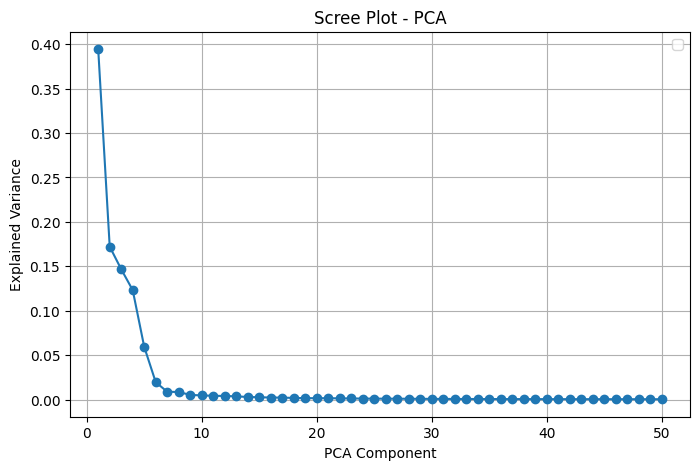

In [177]:
import matplotlib.pyplot as plt

explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("PCA Component")
plt.ylabel("Explained Variance")
plt.title("Scree Plot - PCA")
plt.legend()
plt.grid(True)
plt.show()


We can see clearly here that the explained variance has pretty much zeroed out after 10, so lets try keeping just 10 components to zoom into the best elbow

In [178]:
k = 10

pca = PCA(n_components=k, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat.drop(columns=["obs"]))
X_test_pca  = pca.transform(X_test_flat.drop(columns=["obs"]))

/var/folders/pn/4nppbyxs6cg9m3fhy_ldqchr0000gn/T/ipykernel_16481/1668353091.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


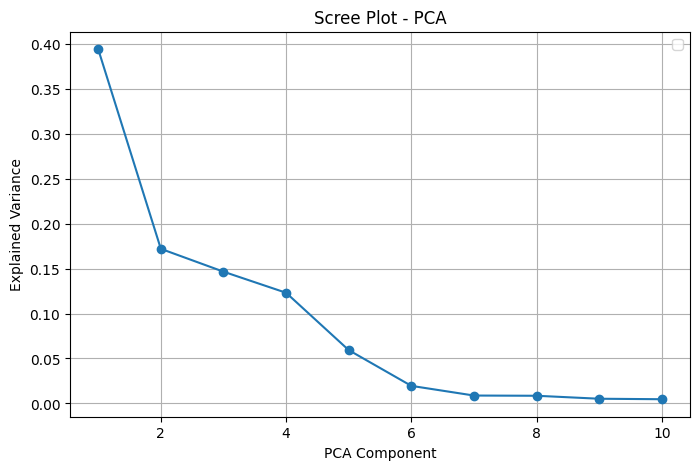

In [179]:
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance = explained_variance_ratio

plt.figure(figsize=(8,5))
plt.plot(range(1, len(cumulative_variance)+1), cumulative_variance, marker='o')
plt.xlabel("PCA Component")
plt.ylabel("Explained Variance")
plt.title("Scree Plot - PCA")
plt.legend()
plt.grid(True)
plt.show()

After getting a good look at the plot, it seems like 6 is the last relevant PCA component, and even that is pretty low. We will try 7 just to be safe, but everything after that we can pretty confidently attribute to noise.

In [180]:
k = 7

pca = PCA(n_components=k, random_state=42)
X_train_pca = pca.fit_transform(X_train_flat.drop(columns=["obs"]))
X_test_pca  = pca.transform(X_test_flat.drop(columns=["obs"]))

In [181]:
rf = RandomForestRegressor(
    n_estimators=500,
    min_samples_leaf=5,
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train_pca, y_train)

,n_estimators,500
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,5
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [ ]:
y_test_pred = rf.predict(X_test_pca)

test_index = X_test_flat[["obs"]].reset_index(drop=True)

pred_df = pd.concat(
    [test_index, pd.DataFrame(y_test_pred, columns=["y_1", "y_2"])],
    axis=1
)

pred_df.head()

,obs,y1_pred,y2_pred
0,18,37.022042,106.290291
1,19,33.796306,101.709704
2,20,33.045393,97.050826
3,21,33.690782,97.579724
4,22,34.334649,95.541467


In [ ]:
# pred_df.to_csv("rf_pca_submission_1.csv", index=False)